# Datenanalyse Unknown

In [1]:
# Base
import numpy as np
import pandas as pd
import gc
from tqdm import tqdm

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Scoring
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Daten laden

In [2]:
train_events = pd.read_csv('../../data/raw/train_events.csv')

## Serien ohne Events entfernen

In [3]:
series_id_list = train_events['series_id'].unique().tolist()
events_series_id_list = train_events.dropna()['series_id'].unique().tolist()
series_without_events = list(set(series_id_list) - set(events_series_id_list))

train_events = train_events[~train_events.series_id.isin(series_without_events)]

##  Unknown state

In [8]:
sequence_length = 24 * 60 * 12 # 17280 Steps = 1 Day
plot_series = False

def remove_duplicates(series_id, buffer_size):
    series = pd.read_parquet('../../data/raw/train_series.parquet', filters=[('series_id','=',series_id)])
    
    ## Unknown
    series['unknown'] = 0
    train_events_filtered = train_events
    true_events = train_events_filtered[train_events_filtered['step'].notna()].reset_index()
    events_with_na = pd.concat([train_events_filtered])
  
    last_event = train_events_filtered.iloc[0]
    for index, row in events_with_na.iterrows():
      if np.isnan(row['step']):
          series.loc[(series['step'] > (last_event['step'] + buffer_size)), 'unknown'] = 1
      else:
          current_idx = true_events[true_events['step'] == row['step']].index
      
          if true_events.shape[0] > (current_idx[0] + 1):
              next_step = true_events.iloc[(current_idx[0] + 1)]['step']
              series.loc[((series['step'] >= row['step']) & (series['step'] < next_step)), 'unknown'] = 0
          elif true_events.shape[0] == (current_idx[0] + 1):
              series.loc[series['step'] >= row['step'], 'unknown'] = 0

          last_event = row

    last_event = train_events.iloc[len(train_events) - 1]
    last_step = series.iloc[len(series) - 1]
    
    if not(np.isnan(last_event['timestamp'])) and last_event['timestamp'][0:10] < last_step['timestamp'][0:10]:
        series.loc[(series['step'] > (last_event['step'] + buffer_size)), 'unknown'] = 1
       
    ## Cleaning
    series['clean'] = 0
    multiplicator = 0
    indices_to_clean = []
    while True:
        # Get 24 Hours (s1) and the next 24 Hours (s2)
        s1 = series[multiplicator*sequence_length:(multiplicator+1)*sequence_length]['anglez'].reset_index(drop=True)
        s2 = series[(multiplicator+1)*sequence_length:(multiplicator+2)*sequence_length]['anglez'].reset_index(drop=True)

        # If the length is not the same, its the last part of the series
        if len(s1) != len(s2):
            # If the last part of the series is the same as the part 24 hours before, remove that as well
            if s1[:len(s2)].equals(s2):
                indices_to_clean.append((len(series)-len(s2), len(series)))
            break

        # If the 24 hours match, remove those indices
        if s1.equals(s2):
            indices_to_clean.append(((multiplicator+1)*sequence_length, (multiplicator+2)*sequence_length))

        multiplicator += 1


    for start_idx, end_idx in indices_to_clean:
        series.loc[series.iloc[start_idx:end_idx].index, 'clean'] = 1
   
    return series

In [9]:
train_data = []

total_len = train_events.series_id.nunique()

#1440 steps = 2 hours

for series_id in tqdm(train_events.series_id.unique()):
    train = remove_duplicates(series_id, 1440)
    train_data.append(train)
    del train
    gc.collect()

train_series_cleaned = pd.concat(train_data).reset_index(drop=True)

  0%|          | 0/269 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_series_cleaned

,series_id,step,timestamp,anglez,enmo,unknown,clean
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,0,0
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,0,0
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,0,0
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,0,0
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,0,0
...,...,...,...,...,...,...,...
124822075,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204,1,0
124822076,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233,1,0
124822077,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202,1,0
124822078,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199,1,0


In [ ]:
train_series_cleaned[train_series_cleaned.clean == 1]

,series_id,step,timestamp,anglez,enmo,unknown,clean
493560,03d92c9f6f8a,103680,2018-06-06T12:00:00-0400,-4.307000,0.0925,1,1
493561,03d92c9f6f8a,103681,2018-06-06T12:00:05-0400,5.529500,0.0746,1,1
493562,03d92c9f6f8a,103682,2018-06-06T12:00:10-0400,18.493601,0.0692,1,1
493563,03d92c9f6f8a,103683,2018-06-06T12:00:15-0400,9.618800,0.0739,1,1
493564,03d92c9f6f8a,103684,2018-06-06T12:00:20-0400,4.323400,0.0646,1,1
...,...,...,...,...,...,...,...
123188035,fb223ed2278c,918355,2019-02-05T15:29:35-0500,-8.031400,0.0237,1,1
123188036,fb223ed2278c,918356,2019-02-05T15:29:40-0500,-8.215200,0.0229,1,1
123188037,fb223ed2278c,918357,2019-02-05T15:29:45-0500,-7.317400,0.0258,1,1
123188038,fb223ed2278c,918358,2019-02-05T15:29:50-0500,-10.651500,0.0328,1,1


## Evaluation

In [ ]:
accuracy_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.7845489676185495

In [ ]:
recall_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.395890078904744

In [ ]:
precision_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.9863680722156711

In [ ]:
f1_score(train_series_cleaned['unknown'], train_series_cleaned['clean'])

0.5650078223406542

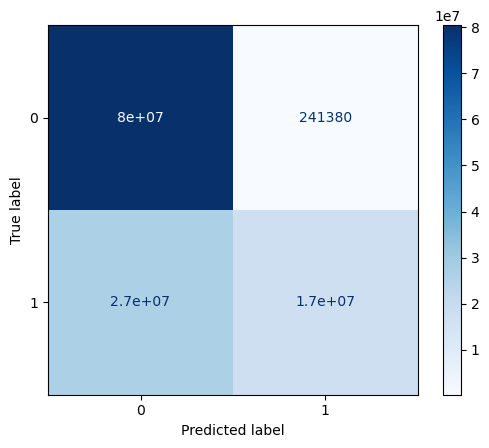

In [ ]:
cm = confusion_matrix(train_series_cleaned['unknown'], train_series_cleaned['clean'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

## Daten speichern für weitere Analysen

In [ ]:
train_series_cleaned.to_parquet('./data/cleaning_analysis.parquet')